In [1]:
%load_ext autoreload
%autoreload 2

In [45]:
# Imports
import os
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
import math

import preprocessing_utils as helper

%matplotlib inline

In [46]:
# Directory setup
BASE_DIR = '..'

TFRECORDS_DIR = '../data/nga_lsms_tfrecords_raw/'
LSMS_CSV_PATH = '../data/nga_lsms_clusters.csv'

EXPORT_DIR = '../data/nga_lsms_tfrecords/'

In [47]:
# avg_rad is the nightlights band
BANDS = ['BLUE', 'GREEN', 'RED', 'NIR', 'SW_IR1', 'SW_IR2', 'TEMP', 'VIIRS', 'DELTA_TEMP']

In [48]:
df_lsms = pd.read_csv(LSMS_CSV_PATH)

# Type conversion to float32
df_lsms['lat'] = df_lsms['lat'].astype(np.float32)
df_lsms['lon'] = df_lsms['lon'].astype(np.float32)
df_lsms['consumption'] = df_lsms['consumption'].astype(np.float32)
df_lsms = df_lsms.sort_values('consumption')

print(df_lsms.dtypes)
display(df_lsms)

country         object
consumption    float32
density          int64
lat            float32
lon            float32
dtype: object


,country,consumption,density,lat,lon
0,nga,0.535630,1,9.981020,9.549433
1,nga,0.540830,1,9.537397,9.502645
2,nga,0.596685,1,12.797704,9.065058
3,nga,0.611105,1,9.083250,9.875452
4,nga,0.618506,1,11.288002,5.919781
...,...,...,...,...,...
4971,nga,46.973923,1,4.581487,7.960589
4972,nga,48.650223,0,9.138173,7.318500
4973,nga,53.263424,0,9.064088,7.478182
4974,nga,68.399483,0,6.241538,6.936829


In [57]:
# Searches for tfrecord by latitude and longitude
# tfrecords = sorted([f for f in os.listdir(EXPORT_DIR) if not f.startswith('.')])
# matched_record = ""

# for tf_r in tfrecords:
#     sample_tfrecord = EXPORT_DIR + tf_r
    
#     feature_set = helper.create_single_feature_set(filename=sample_tfrecord)
#     feature_array = helper.get_feature_array(feature_set=feature_set)
#     lat = np.float32(feature_set['lat'].float_list.value[0])
#     lon = np.float32(feature_set['lon'].float_list.value[0])    
    
#     if ((abs(lat - np.float32(9.346658)) < 1e-8) and (abs(lon - np.float32(42.075893) < 1e-8))):
#         print(f'Matching record found: {tf_r}')
#         matched_record = tf_r
    

# First TFRecord path
sample_tfrecord = EXPORT_DIR + 'nigeria_89_3.tfrecord'

# Get feature array of first record
feature_set = helper.create_single_feature_set(filename=sample_tfrecord)
helper.get_feature_array(feature_set=feature_set)

NotFoundError: {{function_node __wrapped__IteratorGetNext_output_types_1_device_/job:localhost/replica:0/task:0/device:CPU:0}} ../data/nga_lsms_tfrecords/nigeria_89_3.tfrecord; No such file or directory [Op:IteratorGetNext]

(255, 255, 9)
nga: 9.981020, 9.549433


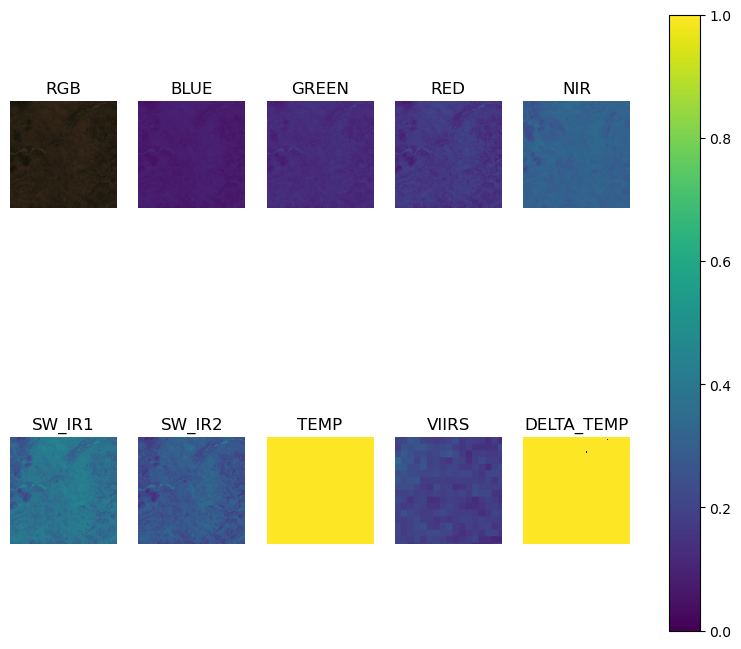

In [52]:
def view_single_record_bands(feature_set):
    lat = np.float32(feature_set['lat'].float_list.value[0])
    lon = np.float32(feature_set['lon'].float_list.value[0])
    country = feature_set['country'].bytes_list.value[0].decode()
    
    band_images = []
    for band_id, band_name in enumerate(BANDS):
        band = np.array(feature_set[band_name].float_list.value, dtype=np.float32).reshape(255, 255)
        band_images.append(band)
    band_images = np.stack(band_images, axis=2)
    print(np.shape(band_images))
    
    print(f'{country}: {lat:4f}, {lon:4f}')
    helper.visualize_bands(img=band_images, band_names=BANDS, bands_per_row=5)
    
    
view_single_record_bands(feature_set=feature_set)

In [53]:
REQUIRED_KEYS = [
    'BLUE', 'GREEN', 'LAT', 'LON', 'VIIRS', 'DELTA_TEMP', 'NIR', 'RED', 'SW_IR1', 'SW_IR2', 'TEMP', 'lat',
    'lon', 'consumption', 'density', 'country'
]

def validate_record(feature_set, record_name):
    # Check for missing bands
    missing_req_keys = [key for key in REQUIRED_KEYS if key not in feature_set]
    if len(missing_req_keys) > 0:
        print(f'Record {record_name} missing required keys: {missing_req_keys}')
        return False
    
    lon = np.float32(feature_set['lon'].float_list.value[0])
    lat = np.float32(feature_set['lat'].float_list.value[0])
    
    # Check middle pixel coordinates
    img_lon = np.float32(np.asarray(feature_set['LON'].float_list.value).reshape(255, 255)[127, 127])
    img_lat = np.float32(np.asarray(feature_set['LAT'].float_list.value).reshape(255, 255)[127, 127])

    if abs(lon - img_lon) > 1e-3:
        print(f'Record {record_name} contains mismatch: "lon"={lon}, "LON"={img_lon}')
        return False
    if abs(lat - img_lat) > 1e-3:
        print(f'Record {record_name} contains invalid lat. "lat"={lat}, "LAT"={img_lat}')
        return False

def process_tfrecords(tfrecord_path, export_dir):
    # Incorrect sorting, solely for visual purposes
    tfrecords = sorted([f for f in os.listdir(tfrecord_path) if not f.startswith('.')])
    
    num_good_records = 0
    for tf_i, tf_r in enumerate(tfrecords):
        filename = tfrecord_path + tf_r
        dataset = tf.data.TFRecordDataset(filenames=[filename])
        
        # Splits each TFRecord file into seperate record files
        for record_i, record in enumerate(iter(dataset)):
            example = tf.train.Example.FromString(record.numpy())
            feature_set = example.features.feature
            
            record_name = f'ethiopia_{tf_i}_{record_i}'
            is_good_record = validate_record(feature_set=feature_set, record_name=record_name)
            
            if is_good_record != False:    
                # Seralize contents of processed record and write
                os.makedirs(export_dir, exist_ok=True)
                export_path = export_dir + f'/{record_name}' + '.tfrecord'
                
                with tf.io.TFRecordWriter(export_path) as writer:
                    writer.write(example.SerializeToString())
                num_good_records += 1
            
            if (record_i + 1) % 25 == 0:
                print(f'Finished validating {record_i + 1} records')
        
        print(f'Finished validating TFRecord {tf_i + 1}')


In [54]:
process_tfrecords(tfrecord_path=TFRECORDS_DIR, export_dir=EXPORT_DIR)

Finished validating 25 records
Finished validating TFRecord 1
Finished validating 25 records
Finished validating TFRecord 2
Finished validating 25 records
Finished validating TFRecord 3
Finished validating 25 records
Finished validating TFRecord 4
Finished validating 25 records
Finished validating TFRecord 5
Finished validating 25 records
Finished validating TFRecord 6
Finished validating 25 records
Finished validating TFRecord 7
Finished validating 25 records
Finished validating TFRecord 8
Finished validating 25 records
Finished validating TFRecord 9
Finished validating 25 records
Finished validating TFRecord 10
Finished validating 25 records
Finished validating TFRecord 11
Finished validating 25 records
Finished validating TFRecord 12
Finished validating 25 records
Finished validating TFRecord 13
Finished validating 25 records
Finished validating TFRecord 14
Finished validating 25 records
Finished validating TFRecord 15
Finished validating 25 records
Finished validating TFRecord 16
F

Finished validating 25 records
Finished validating TFRecord 118
Finished validating 25 records
Finished validating TFRecord 119
Finished validating 25 records
Finished validating TFRecord 120
Record ethiopia_120_12 missing required keys: ['DELTA_TEMP', 'TEMP']
Finished validating 25 records
Finished validating TFRecord 121
Finished validating 25 records
Finished validating TFRecord 122
Finished validating 25 records
Finished validating TFRecord 123
Finished validating 25 records
Finished validating TFRecord 124
Finished validating 25 records
Finished validating TFRecord 125
Finished validating 25 records
Finished validating TFRecord 126
Finished validating 25 records
Finished validating TFRecord 127
Finished validating 25 records
Finished validating TFRecord 128
Finished validating 25 records
Finished validating TFRecord 129
Record ethiopia_129_21 missing required keys: ['DELTA_TEMP', 'TEMP']
Finished validating 25 records
Finished validating TFRecord 130
Finished validating 25 records